Deep Graph Library (DGL)
=====================

DGL is designed to bring machine learning closer to graph-structured data. Specifically DGL enables trouble-free implementation of graph neural network (GNN) model family. Unlike PyTorch or Tensorflow, DGL provides friendly APIs to perform the fundamental operations in GNNs such as message passing and reduction. Through DGL, we hope to benefit both researchers trying out new ideas and engineers in production.

In this tutorial, we demostrate the basics of DGL including:
- How to create a graph?
- How to manipulate node/edge features on a graph?
- How to convert a graph to/from other formats:
- How to perform message passing computation on a graph?
- How to implement a Graph Convolutional Network?

The tutorials requires basic familarity of [pytorch](https://pytorch.org).

In [1]:
# A bit of setup, just ignore this cell
import matplotlib.pyplot as plt

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['animation.html'] = 'html5'

We start by creating the well-knowned *"Zachary's karate club"* social network. The network captures 34 members of a karate club, documenting pairwise links between members who interacted outside the club. The club later splits into two communities led by the instructor (node 0) and club president (node 33). You could read more about the story in the [wiki page](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) A visualization of the network and the community is as follows:

![karate](img/karate.jpg)

Part 1: creating a graph
-----------------------------------

Let's see how we can create such a graph in DGL. We start with importing `dgl` and other relevant packages.

In [2]:
import dgl

We first create an empty `DGLGraph`. In DGL, nodes are consecutive integers start from 0. The following codes add all the club members into this graph (34 nodes).

In [3]:
G = dgl.DGLGraph()
G.add_nodes(34)
print('Number of nodes:', G.number_of_nodes())

Number of nodes: 34


The Karate Club network contains 78 edges:
```
[1 0]
[2 0] [2 1]
[3 0] [3 1] [3 2]
[4 0]
[5 0]
[6 0] [6 4] [6 5]
[7 0] [7 1] [7 2] [7 3]
[8 0] [8 2]
[9 2]
[10 0] [10 4] [10 5]
[11 0]
[12 0] [12 3]
[13 0] [13 1] [13 2] [13 3]
[16 5] [16 6]
[17 0] [17 1]
[19 0] [19 1]
[21 0] [21 1]
[25 23] [25 24]
[27 2] [27 23] [27 24]
[28 2]
[29 23] [29 26]
[30 1] [30 8]
[31 0] [31 24] [31 25] [31 28]
[32 2] [32 8] [32 14] [32 15] [32 18] [32 20] [32 22] [32 23] [32 29] [32 30] [32 31]
[33 8] [33 9] [33 13] [33 14] [33 15] [33 18] [33 19] [33 20] [33 22] [33 23] [33 26] [33 27] [33 28] [33 29] [33 30] [33 31] [33 32]
```

In DGL, edges can be added by specifying the two endpoints.

In [4]:
G.add_edge(1, 0)
print('Now we have %d edges!' % G.number_of_edges())

Now we have 1 edges!


To add multiple edges at once, use a list/tensor of nodes to specify the endpoints.

In [5]:
import torch

########
# NOTE: in DGL, edges are added by specifying a list of source nodes and a list of destination nodes,
# rather than a list of source-destination node pairs. This is different from other popular graph
# package such as networkx, python-igraph.

########
# NOTE: edges in DGLGraphs are all directional.

# add two edges 2->0 and 2->1 using list
G.add_edges([2, 2], [0, 1])

# add three edges 3->0, 3->1 and 3->2 using torch tensor
src = torch.tensor([3, 3, 3])
dst = torch.tensor([0, 1, 2])
G.add_edges(src, dst)

print('Now we have %d edges!' % G.number_of_edges())

Now we have 6 edges!


In [6]:
# add two edges 4->0, 5->0 using list
G.add_edges([4, 5], 0)

# add three edges 6->0 6->4 6->5 using torch tensor
G.add_edges(6, torch.tensor([0, 4, 5]))

print('Now we have %d edges!' % G.number_of_edges())

Now we have 11 edges!


If the edges share the same source or destination nodes, the list/tensor type can be replaced with a single integer.

In [7]:
# Excercise: please finish the karate club graph by adding the remaining edges. We have provided you all the
# remaining edge tuples in a list.

edge_list = [(7, 0), (7, 1), (7, 2), (7, 3), (8, 0), (8, 2), (9, 2), (10, 0), (10, 4), (10, 5),
             (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2), (13, 3), (16, 5), (16, 6),
             (17, 0), (17, 1), (19, 0), (19, 1), (21, 0), (21, 1), (25, 23), (25, 24), (27, 2),
             (27, 23), (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8), (31, 0), (31, 24),
             (31, 25), (31, 28), (32, 2), (32, 8), (32, 14), (32, 15), (32, 18), (32, 20), (32, 22),
             (32, 23), (32, 29), (32, 30), (32, 31), (33, 8), (33, 9), (33, 13), (33, 14), (33, 15),
             (33, 18), (33, 19), (33, 20), (33, 22), (33, 23), (33, 26), (33, 27), (33, 28),
             (33, 29), (33, 30), (33, 31), (33, 32)]

# >>> YOUR CODES START
G.add_edges([f[0] for f in edge_list], [f[1] for f in edge_list])


# <<< YOUR CODES END

# We should have 78 edges now!
print('Now we have %d edges!' % G.number_of_edges())

Now we have 78 edges!


Part 2: manipulating node/edge features
---------------------------------------------------------

Nodes and edges in `DGLGraph` can have **features** tensors. Features of multiple nodes/edges are batched on the first dimension. Let's start by assigning a 5-length random feature vector to all nodes.

In [8]:
G.ndata['feat'] = torch.randn((34, 5))

Now each node has a feature vector `'feat'` that has 5 elements. Note since there are 34 nodes in this graph, the first dimension must be of size 34, so that each row corresponds to the feature vector of each node. Error will be raised if the dimension mismatches:

In [11]:
# This will raise error!!
# G.ndata['wrong_feat'] = torch.randn((35, 5))

The `G.ndata` is a dictionary-like structure, so it is compatible with any operation on dictionary.

In [12]:
# Use `dict.update` to add new features (vector of length 3)
G.ndata.update({'another_feat' : torch.randn((34, 3))})

# Print the feature dictionary
print(G.ndata)

# Delete the new feature using `dict.pop`
G.ndata.pop('another_feat')

{'feat': tensor([[ 0.0560,  0.6238, -0.8865,  0.5675,  0.1091],
        [ 2.7057,  0.6802,  1.7906, -0.3741, -0.4433],
        [ 1.2916,  0.2356, -0.5410,  1.6340,  0.1960],
        [-0.1111,  1.3537, -0.3533, -0.4525, -0.1236],
        [-0.7356,  1.6404, -0.3902, -1.4756,  1.8826],
        [-0.5802, -0.5628,  0.1051, -0.8832, -1.7599],
        [-2.2569,  1.0987, -2.2239,  1.2020,  0.1674],
        [-0.3504, -0.4155, -1.2894, -0.1165,  0.1835],
        [-0.2345, -0.6011, -1.0488, -1.0783, -1.1192],
        [-0.0222, -0.2303,  0.4818, -1.7214,  0.5625],
        [ 0.4743,  0.7430,  1.0683,  0.1477,  0.1142],
        [ 0.1576,  0.2089, -1.1769, -1.1518, -0.3471],
        [ 1.1822, -1.3265, -1.6202, -0.3377, -0.3345],
        [ 1.7521, -1.0717, -0.4673,  1.9736,  0.2437],
        [ 0.1414, -0.4355, -1.2035,  1.6968,  0.3931],
        [-1.5111,  0.4940, -0.1675, -0.2119, -0.8782],
        [-0.4128, -0.2395,  0.7939, -0.7893,  0.2290],
        [ 1.0929, -0.8759,  1.9409, -0.0989,  0.6639],
 

tensor([[-0.4204,  0.1244, -0.7976],
        [ 1.4229,  1.0891, -0.3859],
        [ 0.2872,  0.7767,  2.0064],
        [ 0.7544, -0.4705, -0.0694],
        [-0.8707, -0.8795,  0.3460],
        [-0.5276,  0.7754, -0.6389],
        [ 0.4497, -1.7748, -0.0803],
        [ 1.5345, -0.7401, -0.3679],
        [-0.3730, -1.4544,  0.0863],
        [ 1.1491, -0.0205,  0.5260],
        [ 1.4821,  0.0073,  1.5582],
        [-0.3129, -1.2187, -1.0712],
        [ 1.1079, -0.8713,  0.7424],
        [ 0.4855, -1.5110,  0.4228],
        [-1.1653,  0.3622,  0.2912],
        [-1.1388,  0.7572, -0.9204],
        [-0.8160,  0.5917, -0.9392],
        [ 1.4189,  0.8819,  0.2212],
        [ 0.8519,  0.3050,  0.7871],
        [-1.7052,  1.5680,  0.1164],
        [ 0.2795,  1.6627, -1.0841],
        [-1.1413, -0.4008,  0.6025],
        [ 0.4266, -0.5018,  1.4284],
        [ 0.1070, -0.8345, -0.3161],
        [ 0.2818, -0.0357,  1.2060],
        [-1.7970, -0.0050, -1.6118],
        [-0.4722,  0.8798, -1.2522],
 

Sometimes, you might want to update features of some but not all of the nodes. This can be done using the following syntax:

In [13]:
# Set node 0's feat to be all-zeros vector. Please be aware of the extra size 1 dimension here.
G.nodes[0].data['feat'] = torch.zeros((1, 5))

# Set node 2, 3's feat to be all-ones vector at once using list type.
G.nodes[[2, 3]].data['feat'] = torch.ones((2, 5))

# Set node 10, 11, 12's feat to be all-twos vector at once using tensor type.
to_change = torch.tensor([10, 11, 12])
G.nodes[to_change].data['feat'] = torch.ones((3, 5)) * 2

Similar to `G.ndata` and `G.nodes`, we have `G.edata` and `G.edges` to access and modify edge features:

In [17]:
# The broness edge feature is just a scalar.
G.edata['broness'] = torch.ones((G.number_of_edges(),))

# The instructor (node 0) is a tough guy, so his friends are a little bit scared of him.
G.edges[G.predecessors(0), 0].data['broness'] *= 0.5

print(G.edata)

{'broness': tensor([0.5000, 0.5000, 1.0000, 0.5000, 1.0000, 1.0000, 0.5000, 0.5000, 0.5000,
        1.0000, 1.0000, 0.5000, 1.0000, 1.0000, 1.0000, 0.5000, 1.0000, 1.0000,
        0.5000, 1.0000, 1.0000, 0.5000, 0.5000, 1.0000, 0.5000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.5000, 1.0000, 0.5000, 1.0000, 0.5000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.5000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])}


In [18]:
# Exercise: We know that measuring bro-ness cannot be accurate. Could you add some small random noise to it?
# Hint: Use `torch.randn` to add small permutation to it.
#
G.edata['broness'] = G.edata['broness'] + torch.randn(G.number_of_edges())/10


# <<< YOUR CODES END

# You should see some randomness here
print(G.edata['broness'])

tensor([0.5607, 0.4688, 1.0113, 0.5248, 0.8859, 1.1384, 0.5012, 0.4712, 0.4613,
        0.9509, 0.9979, 0.7024, 0.8233, 1.0284, 1.2116, 0.4430, 0.9811, 0.9546,
        0.4246, 0.9742, 0.9138, 0.5396, 0.3369, 0.8937, 0.4323, 0.9803, 0.8864,
        1.0571, 0.7097, 1.1185, 0.4930, 0.8376, 0.4463, 1.0029, 0.5283, 1.1790,
        0.9239, 1.0379, 0.9799, 1.0877, 1.1109, 1.0167, 1.1504, 1.1187, 0.9173,
        0.9429, 0.3005, 0.9825, 1.0413, 0.9358, 1.1463, 0.9845, 1.1219, 0.9174,
        1.0995, 1.0311, 1.1359, 0.8206, 0.9816, 0.9734, 1.0072, 1.0038, 0.9117,
        0.8567, 1.0192, 0.8880, 0.9418, 0.8312, 0.9189, 1.0396, 1.0368, 1.0634,
        1.0489, 0.7989, 1.1060, 1.0425, 0.9442, 1.2043])


Part 3: converting to/from networkx graph
------------------------------------------------------------

Networkx(https://networkx.github.io/documentation/stable/) is a classical python graph library that has been used for many years. It provides many good utilities to analyze and visualize a graph. `DGLGraph` can be easily converted to/from `networkx` graph very easily:

/home/lee/anaconda3/lib/python3.6/site-packages/dgl/graph.py:656: UserWarning: to_networkx currently does not support converting node/edge features automatically.
  dgl_warning('to_networkx currently does not support converting'


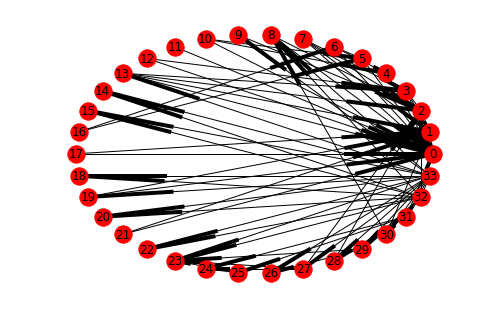

In [19]:
import networkx as nx

nx_G = G.to_networkx()
pos = nx.circular_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True)

Constructing a DGLGraph from networkx is straight-forward. In fact, DGL borrows many of the networkx utilities to create graph from different format:

In [20]:
# from networkx graph
G_from_nx = dgl.DGLGraph(nx_G)  # this gives you the same karate club network

# from edge list
G_from_elist = dgl.DGLGraph([(0,1), (1,2), (2,3)])  # this gives you a chain graph

# from scipy sparse matrix
import scipy.sparse as sp
A = sp.eye(5, 5, 1)
G_from_sp = dgl.DGLGraph(A)  # this also gives you a chain of 5 nodes

Part 4: Message passing on graph
-------------------------------------------------

Many graph neural networks follows the **message passing** computation model -- nodes can send out messages which are then aggregated and used to update the receiver nodes. We go through the basic mechanism of message passing using a toy task and then use it to implement a Graph Convolutional Network (GCN).

Suppose the club president (node 33) is sending out an invitation of their annual karate match. The president also asks the club members to broadcast the news to, of course, their friends in the club. We use a scalar to represent whether the member has received the invitation or not (1 for invited, 0 for not invited). Initially, everyone is 0 except node 33.

In [21]:
# We first convert the uni-directional edges to bi-directional so messages can
#   be sent in both direction.
# We also add a self loop for each node for convenience.
src, dst = G.edges()
GG = dgl.DGLGraph()
GG.add_nodes(34)
GG.add_edges(src, dst)
GG.add_edges(dst, src)
# add self loop for each nodes
v = G.nodes()
GG.add_edges(v, v)
print('We now have %d edges!' % GG.number_of_edges())

# init the state
GG.ndata['invited'] = torch.zeros((34,))
GG.nodes[33].data['invited'] = torch.tensor([1.])
print(GG.ndata['invited'])

We now have 190 edges!
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])


We first define the function that computes the messages. In DGL, the message function is an **Edge UDF** that takes in a single argument `edges`. It has three members `src`, `dst`, and `data` for accessing source node features, destination node features, and edge features respectively.

In [22]:
def message_func(edges):
    # The message is simply the 'invited' state of the source nodes.
    return {'msg' : edges.src['invited']}

Next, we define the reduce function which accumulates and consume the messages to update the node features. In DGL, the reduce function is a **Node UDF** that takes in a single argument `nodes`, which has two members `data` and `mailbox`. `data` contains the node features while `mailbox` contains all incoming message features, stacked along the second dimension (hence the `dim=1` argument).

In [23]:
def reduce_func(nodes):
    # The reduce function sets the 'invited' state to be one if the node has already
    #   been invited or any of the received messages contains an invitation (is one).
    #   This can be done using sum and clamp operations as follows.
    accum = nodes.mailbox['msg'].sum(dim=1)  # note that messages are stacked on dim=1
    return {'invited' : accum.clamp(max=1)}

To trigger the message and reduce function, one can use the `send` and `recv` APIs. Following codes send out the messages from node 33:

In [24]:
# The first argument to `G.send` is the edges along which the messages are sent.
# Note that we can use the same syntax used in adding edges to the graph.
# The second argument is the message function we just defined.
GG.send((33, GG.successors(33)), message_func)

We then call `recv` on the receiver nodes to trigger the reduce function.

In [25]:
GG.recv(GG.successors(33), reduce_func)

/home/lee/anaconda3/lib/python3.6/site-packages/dgl/frame.py:204: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  dgl_warning('Initializer is not set. Use zero initializer instead.'


You can print out the `'invited'` status to see the invitation being propagated.

In [26]:
print(GG.ndata['invited'])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0.,
        1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.])


We can keep doing so until all the nodes received the invitation.

In [27]:
num_invited = int(torch.sum(GG.ndata['invited']))
while num_invited != 34:
    GG.send(GG.edges(), message_func)
    GG.recv(GG.nodes(), reduce_func)
    num_invited = int(torch.sum(GG.ndata['invited']))
    print('%d members have been invited.' % num_invited)

24 members have been invited.
33 members have been invited.
34 members have been invited.


**What's under the hood?**

The key idea here is to automatically batch the node and edge features so that your UDF can compute message passing on multiple nodes and edges in parallel.

```python
def message_func(edges):
    return {'msg' : edges.src['invited']}
```

The `edges` argument is an `EdgeBatch` object representing a batch of edges. It has three members, `src`, `dst`, `data`. The `edges.src['invited']` returns a tensor of shape `(B,)`, where `B` is the number of edges being triggered.

```python
def reduce_func(nodes):
    accum = nodes.mailbox['msg'].sum(dim=1)
    return {'invited' : accum.clamp(max=1)}
```

Similarly, for the reduce function, the argument `nodes` is an `NodeBatch` object representing a batch of nodes. It has two members `data` and `mailbox`. The `nodes.mailbox['msg']` returns a tensor of shape `(B, deg)`, where `B` is the number of nodes that have the same in-degree `deg`. The reduce function will be called *many times* for each degree group.

Part 5: Implementing Graph Convolutional Network (GCN) in DGL
--------------------------------------------------------------

Graph convolutional network (GCN) is a popular model proposed by [Kipf & Welling](https://arxiv.org/abs/1609.02907) to encode graph structure by message passing. The high-level idea is similar to our toy task -- node features are updated by aggregating the messages from the neighbors. Here is its message passing equation:

$$
h_{v_i}^{(l+1)} = \sigma \left(\sum_{j\in\mathcal{N}(i)}\frac{1}{c_{ij}}h_{v_j}^{(l)}W^{(l)} \right)
$$

, where $v_i$ is any node in the graph; $h_{v_i}$ is the feature of node $v_i$; $\mathcal{N}(i)$ denotes the neighborhood of $v_i$; $c_{ij}$ is the normalization constant related to node degrees; $W$ is the parameter and $\sigma$ is a non-linear activation function.

The procedure to implement GCN in DGL is also similar to the toy task:
* Define the message function.
* Define the reduce function.
* Define how they are triggered using `send` and `recv`.

In [28]:
import torch.nn as nn
import torch.nn.functional as F

# Define the message & reduce function
# NOTE: we ignore the normalization constant c_ij for now.
def gcn_message(edges):
    # messages are the features of the source nodes.
    return {'msg' : edges.src['h']}

def gcn_reduce(nodes):
    # messages are summed
    return {'h' : torch.sum(nodes.mailbox['msg'], dim=1)}

# Define the GCN module
class GCN(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCN, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
    
    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first set the node features
        g.ndata['h'] = inputs
        # trigger message passing
        g.send(g.edges(), gcn_message)
        g.recv(g.nodes(), gcn_reduce)
        # get the result node features
        h = g.ndata.pop('h')
        # perform linear transformation
        return self.linear(h)

To test this model, let's try to predict which club member will join whose group (instructor or club president) after the split. We adopt the semi-supervised setting developed by Kipf:

In [29]:
# Clear previous features
GG.ndata.clear()
GG.edata.clear()

# Define a 2-layer GCN model
class Net(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(Net, self).__init__()
        self.gcn1 = GCN(in_feats, hidden_size)
        self.gcn2 = GCN(hidden_size, num_classes)
    
    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        return h

inputs = torch.eye(34)  # featureless inputs
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different
net = Net(34, 5, 2)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

all_logits = []
for epoch in range(30):
    logits = net(GG, inputs)
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for node 0 and node 33
    loss = F.nll_loss(logp[labeled_nodes], labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.6055
Epoch 1 | Loss: 0.4798
Epoch 2 | Loss: 0.4133
Epoch 3 | Loss: 0.3800
Epoch 4 | Loss: 0.3554
Epoch 5 | Loss: 0.3302
Epoch 6 | Loss: 0.2963
Epoch 7 | Loss: 0.2551
Epoch 8 | Loss: 0.2080
Epoch 9 | Loss: 0.1623
Epoch 10 | Loss: 0.1214
Epoch 11 | Loss: 0.0856
Epoch 12 | Loss: 0.0556
Epoch 13 | Loss: 0.0331
Epoch 14 | Loss: 0.0181
Epoch 15 | Loss: 0.0096
Epoch 16 | Loss: 0.0052
Epoch 17 | Loss: 0.0029
Epoch 18 | Loss: 0.0018
Epoch 19 | Loss: 0.0011
Epoch 20 | Loss: 0.0007
Epoch 21 | Loss: 0.0005
Epoch 22 | Loss: 0.0004
Epoch 23 | Loss: 0.0003
Epoch 24 | Loss: 0.0002
Epoch 25 | Loss: 0.0002
Epoch 26 | Loss: 0.0001
Epoch 27 | Loss: 0.0001
Epoch 28 | Loss: 0.0001
Epoch 29 | Loss: 0.0001


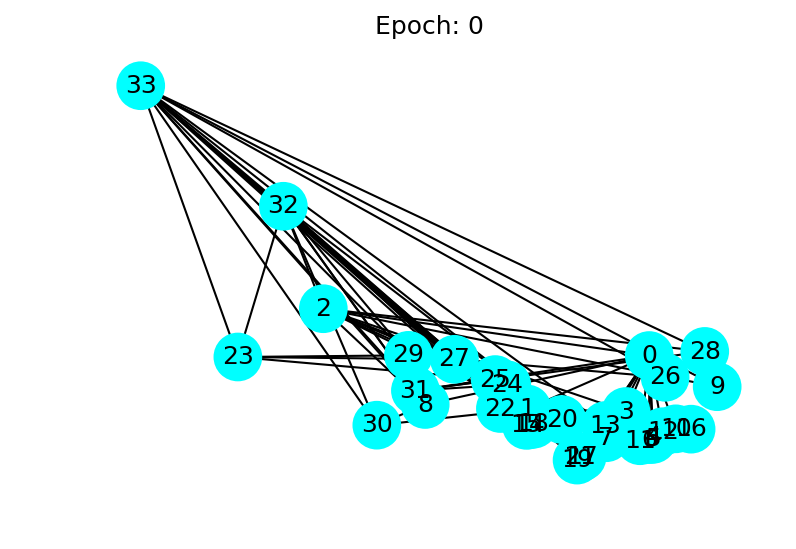

In [30]:
# Visualize the node classification using the logits output.
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = np.argmax(pos[v])
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw(nx_G.to_undirected(), pos, node_color=colors, with_labels=True, node_size=500)

ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)
HTML(ani.to_html5_video())

Advanced Topic: speed up GNN training
--------------------------------------------------

DGL provides many routines that combines basic `send` and `recv` in various ways. They are called **level-2 APIs**. For example, we can use the `update_all` API in the GCN module so that no explicit `edges()` and `nodes()` tensors are generated.

In [31]:
# Re-define the GCN module using level-2 APIs.
class GCN_level2(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCN_level2, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
    
    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first set the node features
        g.ndata['h'] = inputs
        # trigger message passing using `update_all`
        # original codes:
        #   g.send(g.edges(), gcn_message)
        #   g.recv(g.nodes(), gcn_reduce)
        g.update_all(gcn_message, gcn_reduce)
        # get the result node features
        h = g.ndata.pop('h')
        # perform linear transformation
        return self.linear(h)

As some of the message and reduce functions are very commonly used, DGL also provides **builtin functions**. The following codes use `copy_src` and `sum` builtins.

In [32]:
# Re-define the GCN module using DGL builtin functions.
import dgl.function as fn



class GCN_builtin(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCN_builtin, self).__init__()
        self.msg = MessageModule(in_feats, out_feats)
    
    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first set the node features
        g.ndata['h'] = inputs
        # trigger message passing using `update_all`
        # original codes:
        #   g.send(g.edges(), gcn_message)
        #   g.recv(g.nodes(), gcn_reduce)
        g.update_all(self.msg, fn.sum('msg', 'h'))
        # get the result node features
        h = g.ndata.pop('h')
        # perform linear transformation
        return F.relu(h)

Final Quiz
-----------

$$
h_{v_i}^{(l+1)} = \sigma \left(\sum_{j\in\mathcal{N}(i)}\frac{1}{c_{ij}}h_{v_j}^{(l)}W^{(l)} \right)
$$


There is still one missing piece in our GCN model. The normalizer $c_{ij}$ !!. Kipf, in this paper, pointed out that the normalizer should be computed as follows:

$$
c_{ij} = \sqrt{d_id_j}
$$

, where $d_i, d_j$ are the degrees of node $v_i$ and $v_j$ respectively. Your task is to modify the program to implement it.

**Hint#1**: Use `GG.in_degrees(GG.nodes())` to get a 1-D tensor containing the degrees of all the nodes.

**Hint#2**: Since $c_{ij}$ has a subscription $ij$, it is tied to the edges, and our message function is (not coincidently) an **edge UDF**.

Have fun :)

$$
h_{v_i}^{(l+1)} = \sigma \left(\sum_{j\in\mathcal{N}(i)}\alpha_{ij}h_{v_j}^{(l)}W^{(l)} \right) 
\qquad
\alpha_{ij} = \mathrm{softmax}_{j \in \mathcal{N}(i)} (f_a(h_{v_i}, h_{v_j}))
$$

In [47]:
import torch.nn.functional as F

class AttentionScore(nn.Module):
    '''
    Takes in two vectors with `in_features` elements and returns
    a scalar score.
    '''
    def __init__(self, in_features):
        super().__init__()
        
    def forward(self, h_u, h_v):
        '''
        h_u, h_v : (num_examples, in_features)
        returns : (num_examples,)
        '''
        return (h_u * h_v).sum(-1)
    

class MessageModule(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.att = AttentionScore(in_features)
        
    def forward(self, edges):
        '''
        edges is an EdgeBatch object which has three members:
        * src : the features of source nodes as a dictionary
        * dst : the features of destination nodes as a dictionary
        * data : the features on the edges themselves as a dictionary
        
        returns : the message the source node sends to the destination node
        as a dictionary
        '''
        # fn.copy_src('h', 'msg') is equivalent to
        return {
            'msg': self.linear(edges.src['h']),
            'pre_attention_weight': self.att(edges.src['h'], edges.dst['h']),
        }
    
    
class ReduceModule(nn.Module):
    def __init__(self, nonlinear):
        super().__init__()
        self.nonlinear = nonlinear
        
    def forward(self, nodes):
        '''
        nodes is a NodeBatch object which has two members:
        * data : the features on the nodes themselves as a dict
        * mailbox : the dict of incoming messages.  The values are
        stacked along the second dimension.
        '''
        #nodes.mailbox = {'msg': (num_nodes, num_incoming_messages, out_features),
        #                 'pre_attention_weight': (num_nodes, num_incoming_messages)}
        a = F.softmax(nodes.mailbox['pre_attention_weight'], 1)
        h = (a[:, :, None] * nodes.mailbox['msg']).sum(1)
        return {'h': self.nonlinear(h)}


class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, nonlinear=F.leaky_relu):
        super().__init__()
        
        self.f_a = AttentionScore(in_features)
        self.msg = MessageModule(in_features, out_features)
        self.reduce = ReduceModule(nonlinear)
        
    def forward(self, g, inputs):
        '''
        g : DGLGraph
        inputs : node features h (num_nodes, in_features)
        '''
        # g is the graph and the inputs is the input node features
        # first set the node features
        g.ndata['h'] = inputs
        
        g.update_all(self.msg, self.reduce)
        # get the result node features
        h = g.ndata.pop('h')
        
        return h

In [48]:
# Clear previous features
GG.ndata.clear()
GG.edata.clear()

# Define a 2-layer GCN model
class Net(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(Net, self).__init__()
        self.gcn1 = GATLayer(in_feats, hidden_size)
        self.gcn2 = GATLayer(hidden_size, num_classes)
    
    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        return h

inputs = torch.eye(34)  # featureless inputs
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different
net = Net(34, 5, 2)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

all_logits = []
for epoch in range(30):
    logits = net(GG, inputs)
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for node 0 and node 33
    loss = F.nll_loss(logp[labeled_nodes], labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.6986
Epoch 1 | Loss: 0.6953
Epoch 2 | Loss: 0.6923
Epoch 3 | Loss: 0.6894
Epoch 4 | Loss: 0.6866
Epoch 5 | Loss: 0.6836
Epoch 6 | Loss: 0.6805
Epoch 7 | Loss: 0.6772
Epoch 8 | Loss: 0.6738
Epoch 9 | Loss: 0.6701
Epoch 10 | Loss: 0.6687
Epoch 11 | Loss: 0.6653
Epoch 12 | Loss: 0.6604
Epoch 13 | Loss: 0.6553
Epoch 14 | Loss: 0.6514
Epoch 15 | Loss: 0.6472
Epoch 16 | Loss: 0.6424
Epoch 17 | Loss: 0.6372
Epoch 18 | Loss: 0.6315
Epoch 19 | Loss: 0.6255
Epoch 20 | Loss: 0.6190
Epoch 21 | Loss: 0.6120
Epoch 22 | Loss: 0.6067
Epoch 23 | Loss: 0.6004
Epoch 24 | Loss: 0.5931
Epoch 25 | Loss: 0.5851
Epoch 26 | Loss: 0.5790
Epoch 27 | Loss: 0.5726
Epoch 28 | Loss: 0.5655
Epoch 29 | Loss: 0.5576


In [46]:
loss

tensor(0.6931, grad_fn=<NllLossBackward>)